In [47]:
import ptvsd
ptvsd.enable_attach(('0.0.0.0', 3000))

# Preamble

## AsyncIO

In [1]:
from distutils.version import StrictVersion
import IPython
import ipykernel
if StrictVersion(IPython.__version__) <= StrictVersion('7.0.0'):
    pass
elif StrictVersion(ipykernel.__version__) <= StrictVersion('5.0.0'):
    pass
else:
    %autoawait off
    %autoawait

IPython autoawait is `off`, and set to use `asyncio`


In [2]:
import asyncio

In [3]:
loop = asyncio.get_event_loop()

In [4]:
loop.is_running()

False

In [5]:
async def sleepy_print(msg):
    await asyncio.sleep(2)
    print(msg)

Use `ensure_future` to schedule a task for execution in the notebook.

In [6]:
asyncio.ensure_future(sleepy_print("Hello!"))

<Task pending coro=<sleepy_print() running at <ipython-input-5-34b39703b84d>:1>>

In [7]:
async def task():
    await asyncio.sleep(5)
asyncio.get_event_loop().run_until_complete(task())

Hello!


In [8]:
%matplotlib notebook

# %qtconsole

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes as qc
from qcodes.instrument.parameter import Parameter
from qcodes.math.field_vector import FieldVector
from qcodes.dataset.experiment_container import new_experiment
from qcodes.utils.async_utils import sync, cancelling

In [9]:
from pytopo.field_optimization.movement import FieldOptimizationProblem

In [10]:
# from typing import Callable, Optional, TypeVar, Union
# TODO: Define a type hint for callables that act like QCoDeS parameters,
#       that is as objects which support both Callable[None, T] and
#       Callable[T, None].

In [11]:
from pytopo.qctools import instruments as instools
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.sweep.base import Nest, Chain
from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure

from pytopo.field_optimization.transform import TransformedController

In [12]:
# from contextlib import contextmanager

# Define measurement functions

In [13]:
def setup_frq_sweep(fstart, fstop, fpts, chan='S21', bw=None, navgs=None, pwr=None):
    """
    Setup a VNA trace.
    
    assumes that a channel with name chan is already created.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(fstart, fstop, fpts)
    trace.start(fstart)
    trace.stop(fstop)
    trace.npts(fpts)
    if navgs is not None:
        trace.avg(navgs)
    if bw is not None:
        trace.bandwidth(bw)
    if pwr is not None:
        trace.power(pwr)
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()
    
    return fvals

def take_trace(chan='S21', plot=False):
    """
    Get the data of a currently measured trace.
    The trace has to be setup already.
    
    Returns magnitude (in dB) and phase (in rad).
    
    If plot is true, make a simple plot of the magnitude vs frequency.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
    mag, phase = trace.trace_mag_phase()
    
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(fvals*1e-9, 20*np.log10(mag))
        ax.grid(dashes=[1,1])
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Magnitude (dBm)')
        
    return mag, phase


def setup_zerospan_trace(frq, npts, chan='S21', span=1.):
    """
    Setup the VNA to measure a trace around <frq> with <npts> samples
    in a very narray frequency span.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    trace.center(frq)
    trace.span(span)
    trace.npts(npts)
    
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()

        
### pytopo.sweep measurement functions

@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('amplitude', '', 'array'), ('phase', 'rad', 'array')]
)
def vna_frequency_sweep(*arg, **kw):
    """
    Measurement function for a simple VNA trace for pytopo.sweep.
    
    All arguments will be passed to setup_trace.
    Return data is as returned by take_trace.
    """
    fvals = setup_frq_sweep(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return fvals, np.vstack((mag, phase))

@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('magnitude', 'dB', 'array'), ('phase', 'rad', 'array')]
)
def vna_frequency_sweep_dB(*arg, **kw):
    """
    Measurement function for a simple VNA trace for pytopo.sweep.
    t
    All arguments will be passed to setup_trace.
    Return data is as returned by take_trace.
    """
    fvals = setup_frq_sweep(*arg, **kw)
    mag, phase = take_trace(plot=False)
    time.sleep(1)
    
    return fvals, np.vstack((20*np.log10(mag), phase))

@hardsweep(
    ind=[('iteration', '', 'array')], 
    dep=[('amplitude', '', 'array'), ('phase', 'rad', 'array')]
)
def vna_timetrace(*arg, **kw):
    """
    Measure a 'time trace', emulated by a narrow span trace with many points.
    """
    setup_zerospan_trace(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return np.arange(mag.size), np.vstack((mag, phase))


@hardsweep(
    ind=[('iteration', '', 'array')], 
    dep=[('magnitude', 'dB', 'array'), ('phase', 'rad', 'array')]
)
def vna_timetrace(*arg, **kw):
    """
    Measure a 'time trace', emulated by a narrow span trace with many points.
    """
    setup_zerospan_trace(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return np.arange(mag.size), np.vstack((20*np.log10(mag), phase))


@getter(('signal', 'dB'), ('noise', 'dB'), ('SNR', 'dB'))
def get_SNR():
    """
    extract SNR from a trace: take sig=mean(trace) and noise=std(trace),
    where trace is the complex linear amplitude.
    return signal, noise, and snr in dB(!).
    
    does not setup the VNA. you should do that manually before calling this method.
    """
    time.sleep(0.01)
    mag, phase = take_trace(plot=False)
    sig = np.abs(mag) * np.exp(-1j*phase)
    lin_mean = np.abs(sig.mean())
    lin_std = np.abs(sig.std())
    return 20*np.log10(lin_mean), 20*np.log10(lin_std), 20*np.log10(lin_mean/lin_std)



In [14]:
it = Parameter('iteration', set_cmd=None, initial_value=1)

# Init station

## Global variables

In [15]:
SAMPLE = "FluxoniumTest_CD20181015"

## Init instruments

In [16]:
%run -i D:/OneDrive/BF2/Code/BF2/BF2/init_station.py

In [17]:
from qcodes.instrument_drivers.rohde_schwarz.ZNB import ZNB
vna = create_inst(ZNB, 'vna', address='TCPIP::169.254.62.18::inst0::INSTR', force_new_instance=True)
station = qc.Station(vna)

# the VNA driver has some weird default settings. 
# Make sure here that we measure what we want
vna.clear_channels()
vna.add_channel('S21')
vna.S21.power(-50)
vna.rf_off()

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101971, firmware:2.90) in 0.25s


In [18]:
from qcodes.instrument_drivers.oxford.MercuryiPS_VISA import MercuryiPS
mgnt = create_inst(MercuryiPS, 'mgnt', address='TCPIP0::169.254.111.111::7020::SOCKET', force_new_instance=True)

station = add2station(station, mgnt)

# Current/field conversion for QT2:
# This only seems to work in engineering mode, though.
# mgnt.GRPX.ATOB(68.3)
# mgnt.GRPY.ATOB(67.7) 
# mgnt.GRPZ.ATOB(11.96)

print("PS A/T:", mgnt.GRPX.ATOB(), mgnt.GRPY.ATOB(), mgnt.GRPZ.ATOB())
print("Deviation:", mgnt.GRPX.ATOB()/68.3, mgnt.GRPY.ATOB()/67.7, mgnt.GRPZ.ATOB()/11.96)

Connected to: OXFORD INSTRUMENTS MERCURY IPS (serial:123550029, firmware:2.6.04.000) in 0.24s
PS A/T: 58.312 58.433 18.12
Deviation: 0.8537628111273792 0.8631166912850812 1.5150501672240801


In [19]:
field_controller = (
    TransformedController(mgnt)
        .rescale(
            68.3  / mgnt.GRPX.ATOB(),
            67.7  / mgnt.GRPY.ATOB(),
            11.96 / mgnt.GRPZ.ATOB()
        )
        .rotate_y_deg(180)
#         .shift(FieldVector(0, 0, 0.1))
)

In [20]:
print(mgnt.field_measured().repr_spherical())
print(field_controller.field_measured().repr_spherical())

FieldVector(r=0.31722309184547076, phi=179.58869493677142, theta=153.9513310466426)
FieldVector(r=0.24901585204157137, phi=2.5153429615791434, theta=6.085663776349101)


In [21]:
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
twpa_pump = create_inst(RohdeSchwarz_SGS100A, 'twpa_pump', address="TCPIP::169.254.167.18::inst0::INSTR")
station = add2station(station, twpa_pump)

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110531, firmware:3.1.19.15-3.50.124.67) in 0.03s


# Testing

## Quick manual trace (without saving)

<IPython.core.display.Javascript object>


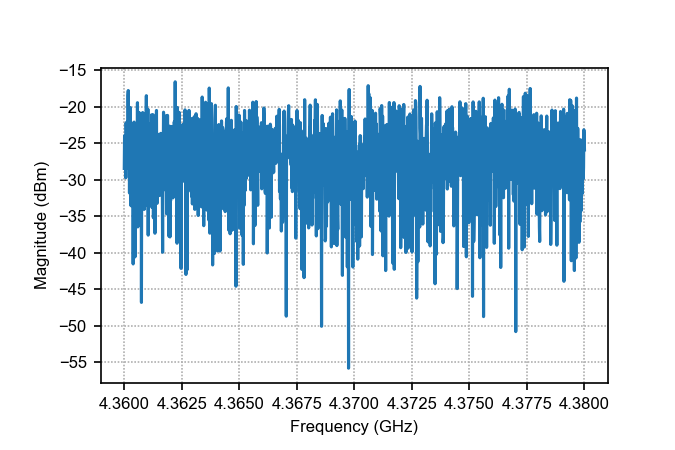

In [27]:
setup_frq_sweep(fstart=(4.37-0.01)*1e9, fstop=(4.37+0.01)*1e9, fpts=1501, pwr=-50)
mag, phase = take_trace(plot=True)

In [28]:
vna.S21.autoscale()

# Take a single VNA trace

In [22]:
sweep_obj = vna_frequency_sweep_dB(fstart=4.365e9, fstop=4.375e9, fpts=10001, chan='S21')
result = do_experiment(f"VNA/{SAMPLE}", sweep_obj, live_plot=True)

Upgrading database: 100%|████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 85.12it/s]


NameError: name 'o' is not defined

# Power dependence

In [ ]:
vna.S21.avg(10)

In [ ]:
starts = [4.355e9, 3.7555e9, 3.543e9, 3.159e9, 3.0e9]
spans = 4 * [40e6] + [2e9]

for f0, fspan in zip(starts, spans):
    sweep_obj = sweep(vna.S21.power, np.arange(-60., -9., 5.))(
        vna_trace(fstart=f0, fstop=f0+fspan, fpts=4001, chan='S21', bw=1e3)
    )
    result = do_experiment(f"VNA_powersweep/{SAMPLE}", sweep_obj, live_plot=True)

# TWPA pump tune up

## VNA as function of pump power

In [ ]:
sweep_obj = sweep(twpa_pump.power, np.arange(2.5, 8.5, .2))(
    vna_trace(fstart=2e9, fstop=7e9, fpts=1001, chan='S21', navgs=1)
)

result = do_experiment(f"VNA_vs_pump_power/{SAMPLE}", sweep_obj, live_plot=True)

## VNA as function of pump frq

In [ ]:
sweep_obj = sweep(twpa_pump.frequency, np.arange(7.7e9, 8.4e9, 10e6))(
    vna_trace(fstart=2e9, fstop=7e9, fpts=1001, chan='S21', navgs=1)
)

result = do_experiment(f"VNA_vs_pump_frequency/{SAMPLE}", sweep_obj, live_plot=True)

## SNR as function of pump params

In [ ]:
twpa_pump.on()
vna.S21.avg(1)
vna.S21.power(-50)
setup_zerospan_trace(4.5e9, 201)


sweep_obj = sweep(twpa_pump.frequency, np.arange(7.95e9, 8.05e9, 0.5e6))(
    sweep(twpa_pump.power, np.arange(0.0, 12.0, .1)))(
        measure(get_SNR)
)

result = do_experiment(f"TWPA_SNR/{SAMPLE}", sweep_obj, live_plot=True)

# VNA vs Magnet Measurements

## Step 1: play with magnet

In [22]:
mgnt.IDN()

{'model': 'MERCURY IPS',
 'vendor': 'OXFORD INSTRUMENTS',
 'serial': '123550029',
 'firmware': '2.6.04.000'}

In [23]:
field_controller.field_measured()

FieldVector(x=0.026374047130527767, y=0.0011585918915681208, z=0.2476125236549542)

In [24]:
print(f'Magnet reached {field_controller.field_measured().repr_spherical()}', end='\r')

In [45]:
from ipywidgets import Label
from IPython.display import display

In [53]:
async def report_field():
    while True:
        print(f'Magnet reached {field_controller.field_measured().repr_spherical()}', end='\r')
        await asyncio.sleep(1)
  
# This isn't quite working yet.
# async def report_field():
#     try:
#         widget = Label()
#         display(widget)
#         while True:
#             widget.label = f'Magnet reached {field_controller.field_measured().repr_spherical()}'
#             await asyncio.sleep(1)
#     except asyncio.CancelledError:
#         widget.close()

In [33]:
# %autoawait seems a bit unstable still...
# mgnt.field_target(FieldVector(0.1, 0, 0))
# asyncio.ensure_future(report_field())a

# await mgnt.ramp_async()

In [25]:
mgnt.GRPY.field()

0.001

In [26]:
mgnt.field_measured()

FieldVector(x=-0.1393, y=0.001, z=-0.285)

In [52]:
# w/o %autoawait
async def task():
    mgnt.field_target(FieldVector(0.15, 0, 0.2))
    with cancelling(asyncio.ensure_future(report_field())):
        await mgnt.ramp_async()
asyncio.get_event_loop().run_until_complete(task())

A Jupyter Widget

KeyboardInterrupt: 

## Optimizing the field orientation

### tool functions

In [30]:
def get_trace_min(frqvals, trace):
    return frqvals[np.argmin(trace)], trace[np.argmin(trace)]

def find_frequency(frqvals, trace, method=get_trace_min, plot=False):
    f0, y0 = method(frqvals, trace)
    
    if plot:
        fig, ax = plt.subplots(1,1)
        ax.plot(frqvals, trace, 'o-', mfc='None', mew=0.5, lw=0.5)
        ax.grid(dashes=[1,1])
        ax.set_xlabel('Frequency')
        ax.set_ylabel('S21 (dBm)')
        r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
        ax.set_title('B = %.3f, phi = %.1f, theta = %.1f' %(r, phi, theta))
        
        ax.plot([f0], [y0], '*', ms=10, mew=1, mfc='None')
        
    return f0

# def step_field_spherical(dr, dphi, dtheta, nsteps):
#     pass

In [31]:
def frequency_parameter():
    fstart = 4.375e9 - 80e6
    fstop = fstart + 160e6
    fvals = setup_frq_sweep(fstart, fstop, 2001)
    trace = 20*np.log10(take_trace()[0])
    return find_frequency(fvals, trace)

In [32]:
from scipy.optimize import curve_fit
from functools import partial

In [33]:
def cauchy_model(freq, amplitude, offset, location, scale):
    return amplitude / (np.pi * scale * (1 + ((freq - location) / scale) ** 2)) + offset

def meas_cauchy_trace(center_freq, freq_window, n_freqs=1001, freq_est_method=get_trace_min):
    f_start = center_freq - freq_window / 2
    f_stop = f_start + freq_window
    freqs = setup_frq_sweep(f_start, f_stop, n_freqs)
    
    trace = take_trace()[0]
    
    center_freq, center_amplitude = freq_est_method(freqs, trace)
    
    # Guess the amplitude, offset, and location.
    amp_guess = -4e6
    offset_guess = trace[0]
    location_guess = center_freq
    guess = np.array([amp_guess, offset_guess, location_guess, 1e6])
    
    # Fit a Cauchy, using the guess above as a starting point.
    model = cauchy_model
    p_opt, p_cov = curve_fit(
        model, freqs, trace,
        guess
    )
    
    return trace, p_opt

In [34]:
def frequency_uncertianty_parameter():
    center = frequency_parameter()
    trace, p_opt = meas_cauchy_trace(center, 40e6)
    return p_opt[3]

In [35]:
field_opt = FieldOptimizationProblem(field_controller, frequency_parameter, frequency_uncertianty_parameter)

In [36]:
# w/o %autoawait
async def task():
    mgnt.field_target(FieldVector(0.15, 0, 0.2))
    with cancelling(asyncio.ensure_future(report_field())):
        await field_opt.set_field_async(FieldVector(r=0.245, phi=0, theta=10), absolute=True, ramp_rate=3e-3, verbose=True)
asyncio.get_event_loop().run_until_complete(task())

Setting field target to FieldVector(r=0.17357095414675172, phi=180.0, theta=160.6199635656091)
Setting field target to FieldVector(r=0.09077570060106055, phi=180.0, theta=155.53786238867062)
Setting field target to FieldVector(r=0.019951958804820338, phi=180.0, theta=42.81664151296816)
Setting field target to FieldVector(r=0.10569753023993281, phi=0.0, theta=4.786987783269095)
Setting field target to FieldVector(r=0.17527590509579444, phi=0.0, theta=8.411437829176476)
Setting field target to FieldVector(r=0.21716628191822654, phi=0.0, theta=9.473330033031761)
Setting field target to FieldVector(r=0.2367058912211265, phi=0.0, theta=9.845616166441001)
Setting field target to FieldVector(r=0.24328311112944928, phi=0.0, theta=9.98694538523375)
Setting field target to FieldVector(r=0.24480560388380435, phi=0.0, theta=10.005158831509334)
Setting field target to FieldVector(r=0.245, phi=0.0, theta=10.000000000000012)3)43)
Move complete. FieldVector(r=0.2449115318024542, phi=0.0, theta=10.0061

In [37]:
print(f"Physical:    {mgnt.field_measured().repr_spherical()}")
print(f"Transformed: {field_controller.field_measured().repr_spherical()}")

Physical:    FieldVector(r=0.3015381402078351, phi=-180.0, theta=150.71470066058774)
Transformed: FieldVector(r=0.2449115318024542, phi=0.0, theta=10.006196303361302)


<IPython.core.display.Javascript object>


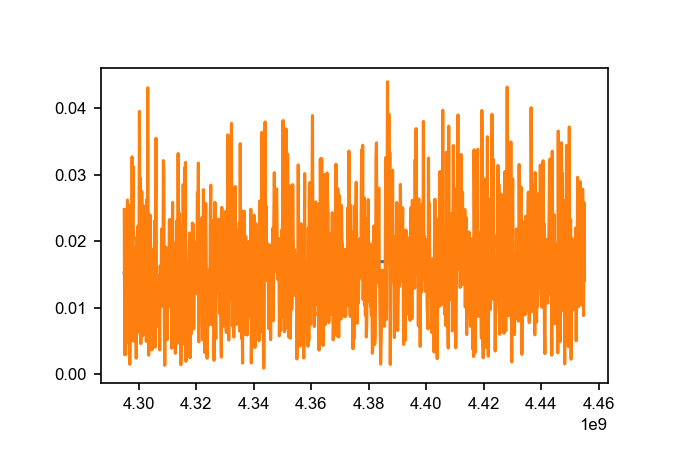

In [42]:
fstart = 4.375e9 - 80e6
fstop = fstart + 160e6
fvals = setup_frq_sweep(fstart, fstop, 1001)

plt.figure()
trace, fit = meas_cauchy_trace(4.375e9, 160e6)
plt.plot(fvals, cauchy_model(fvals, *fit))

f0 = find_frequency(fvals, 20 * np.log10(trace), plot=False)
plt.plot(fvals, trace)


In [39]:
print(f'Magnet reached (r, phi, theta) = {mgnt.field_measured().repr_spherical()}', end='\r')

In [40]:
print(f'Magnet reached (r, phi, theta) = {field_controller.field_measured().repr_spherical()}', end='\r')

In [41]:
field_controller.field_target._transform

array([[-0.96113469,  0.        ,  0.37723514,  0.        ],
       [ 0.        ,  1.15859189,  0.        ,  0.        ],
       [-0.66942499,  0.        , -0.54161973,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Evaluating at phi = 0.0, theta = 10.0
Move complete. (r, phi, theta) = (0.24895299668599813, 0.0, 9.993264717186664)
Evaluating at phi = -2.0, theta = 10.0
Move complete. (r, phi, theta) = (0.24895755281850343, -1.9967451876414002, 9.999213739497197)
Evaluating at phi = 2.0, theta = 10.0
Move complete. (r, phi, theta) = (0.24895755281850343, 1.9967451876414002, 9.999213739497197)
Evaluating at phi = 2.0, theta = 6.000000000000001
Move complete. (r, phi, theta) = (0.24936878723515732, 2.511412177537524, 6.086559525201429))
Evaluating at phi = 0.0, theta = 6.000000000000001
Move complete. (r, phi, theta) = (0.24900943973026532, 0.0, 6.00927205360341).009330968351448)
Evaluating at phi = -2.0, theta = 6.000000000000001
Move complete. (r, phi, theta) = (0.24901076044824755, -1.7819379045192298, 6.0121581773302255)
Evaluating at phi = -2.0, theta = 14.0
Move complete. (r, phi, theta) = (0.24830838097893132, -2.002323680679576, 13.908643753340323))
Evaluating at phi = 0.0, theta = 14.0
Move 

<IPython.core.display.Javascript object>


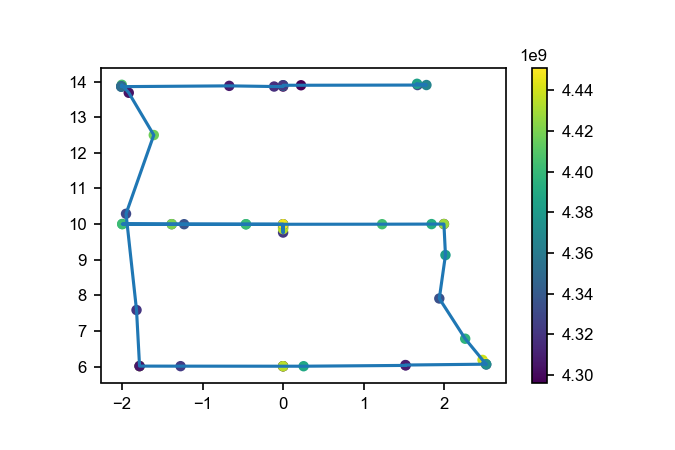

In [40]:
opt, extra = sync(field_opt.optimize_at_fixed_magnitude(
    0.249, (-2, +2), 3,(6, 14), 3,
    plot=True, return_extra=True
))

In [ ]:
optimum, extra = sync(field_opt.optimize_and_ramp_magnitude(
    0.249, 0.4, 10,
    0, 5, 3,
    10, 8, 3,
    reoptimization_threshold=0.5,
    ramp_rate=3e-3,
    return_extra=True
))

In [ ]:
plt.figure()
plt.plot(
    [field.phi for field in extra['history']['optima']],
    [field.theta for field in extra['history']['optima']],
    zorder=-10
)
plt.scatter(
    [field.phi for field in extra['history']['optima']],
    [field.theta for field in extra['history']['optima']],
    c=[field.r for field in extra['history']['optima']]
)
plt.colorbar()

In [ ]:
extra

In [ ]:
plt.figure()
plt.plot(extra['history']['objectives'])

In [ ]:
fstart = 3e9 
fstop = 5e9
fvals = setup_frq_sweep(fstart, fstop, 10001, navgs=1, pwr=-50)
mgnt.GRPX.field_ramp_rate(4e-3)
mgnt.GRPY.field_ramp_rate(4e-3)
mgnt.GRPZ.field_ramp_rate(4e-3)
dr, dphi, dtheta = -0.001, +0.0, 0.0
fig, ax = plt.subplots(1,1)
mgnt.ramp(mode='safe')
print(f'Magnet reached {mgnt.field_measured().repr_spherical()}', end='\r')
for i in range(1):
    print(i)
    r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
    r1, phi1, theta1 = r+dr, phi+dphi, theta+dtheta
    mgnt.r_target(r1)
    mgnt.phi_target(phi1)
    mgnt.theta_target(theta1)
    mgnt.ramp(mode='safe')
    
    time.sleep(0.1)
    trace = 20*np.log10(take_trace()[0])
    ax.plot(fvals, trace, '-', mfc='None', mew=0.5, lw=0.5, color = (1,0,1-0.1*i), label='B = %.3f, phi = %.1f, theta = %.1f' %(r1, phi1, theta1))
    r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
    time.sleep(0.1)
    
ax.grid(dashes=[1,1])
ax.set_ylabel('S21 (dBm)')
ax.set_xlabel('Frequency (GHz)')
ax.legend()

In [ ]:
mgnt.theta_measured()

In [ ]:
r2, phi2, theta2 = r1, phi1, theta1

In [ ]:
fvals2 = fvals
trace2 = trace

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(fvals2, trace2, '-', mfc='None', mew=0.5, lw=0.5, color='b', label='B = %.3f, phi = %.1f, theta = %.1f' %(r2, phi2, theta2))
ax.plot(fvals, trace, '-', mfc='None', mew=0.5, lw=0.5, color='r', label='B = %.3f, phi = %.1f, theta = %.1f' %(r1, phi1, theta1))

ax.grid(dashes=[1,1])
ax.set_ylabel('S21 (dBm)')
ax.set_xlabel('Frequency (GHz)')
ax.legend()    

In [ ]:
mgnt.r_measured()

### New heading